In [1]:
#!pip3 install fix_yahoo_finance
#!pip3 install pandas_datareader

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd
import yfinance as yahoo_finance  

# for pandas_datareader, otherwise it might have issues
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time

#yahoo API data source correction
#import fix_yahoo_finance as yahoo_finance
yahoo_finance.pdr_override()

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A double top is an extremely bearish technical reversal pattern that forms after an asset reaches a high price two consecutive times with a moderate decline between the two highs. It is confirmed once the asset's price falls below a support level equal to the low between the two prior highs.

Most descriptions of a double top include two price peaks and a supporting neck line.

It is this neckline that must be broken for the double top pattern to be completed.
However, coding this pattern is more tricky than it sounds because we need to be specific about certain criteria such as:

How to define the first peak A?
How much should the high at peak A differ from the high at peak C?
What should the distance be between the neckline and the highest peak?
How many bars should there be between peak A and peak C?
What is the maximum number of bars that the pattern should complete within?

In [3]:
# ___variables___
ticker = 'AAPL'
start_time = datetime.datetime(2019, 10, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

# yahoo gives only daily historical data
connected = False
while not connected:
    try:
        ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   

# use numerical integer index instead of date    
ticker_df = ticker_df.reset_index()
print(ticker_df.head(5))

[*********************100%***********************]  1 of 1 completed
connected to yahoo
        Date       Open       High        Low      Close  Adj Close     Volume
0 2019-10-01  56.267502  57.055000  56.049999  56.147499  54.932762  139223200
1 2019-10-02  55.764999  55.895000  54.482498  54.740002  53.555717  138449200
2 2019-10-03  54.607498  55.240002  53.782501  55.205002  54.010662  114426000
3 2019-10-04  56.410000  56.872501  55.972500  56.752499  55.524673  138478800
4 2019-10-07  56.567501  57.482498  56.459999  56.764999  55.536907  122306000


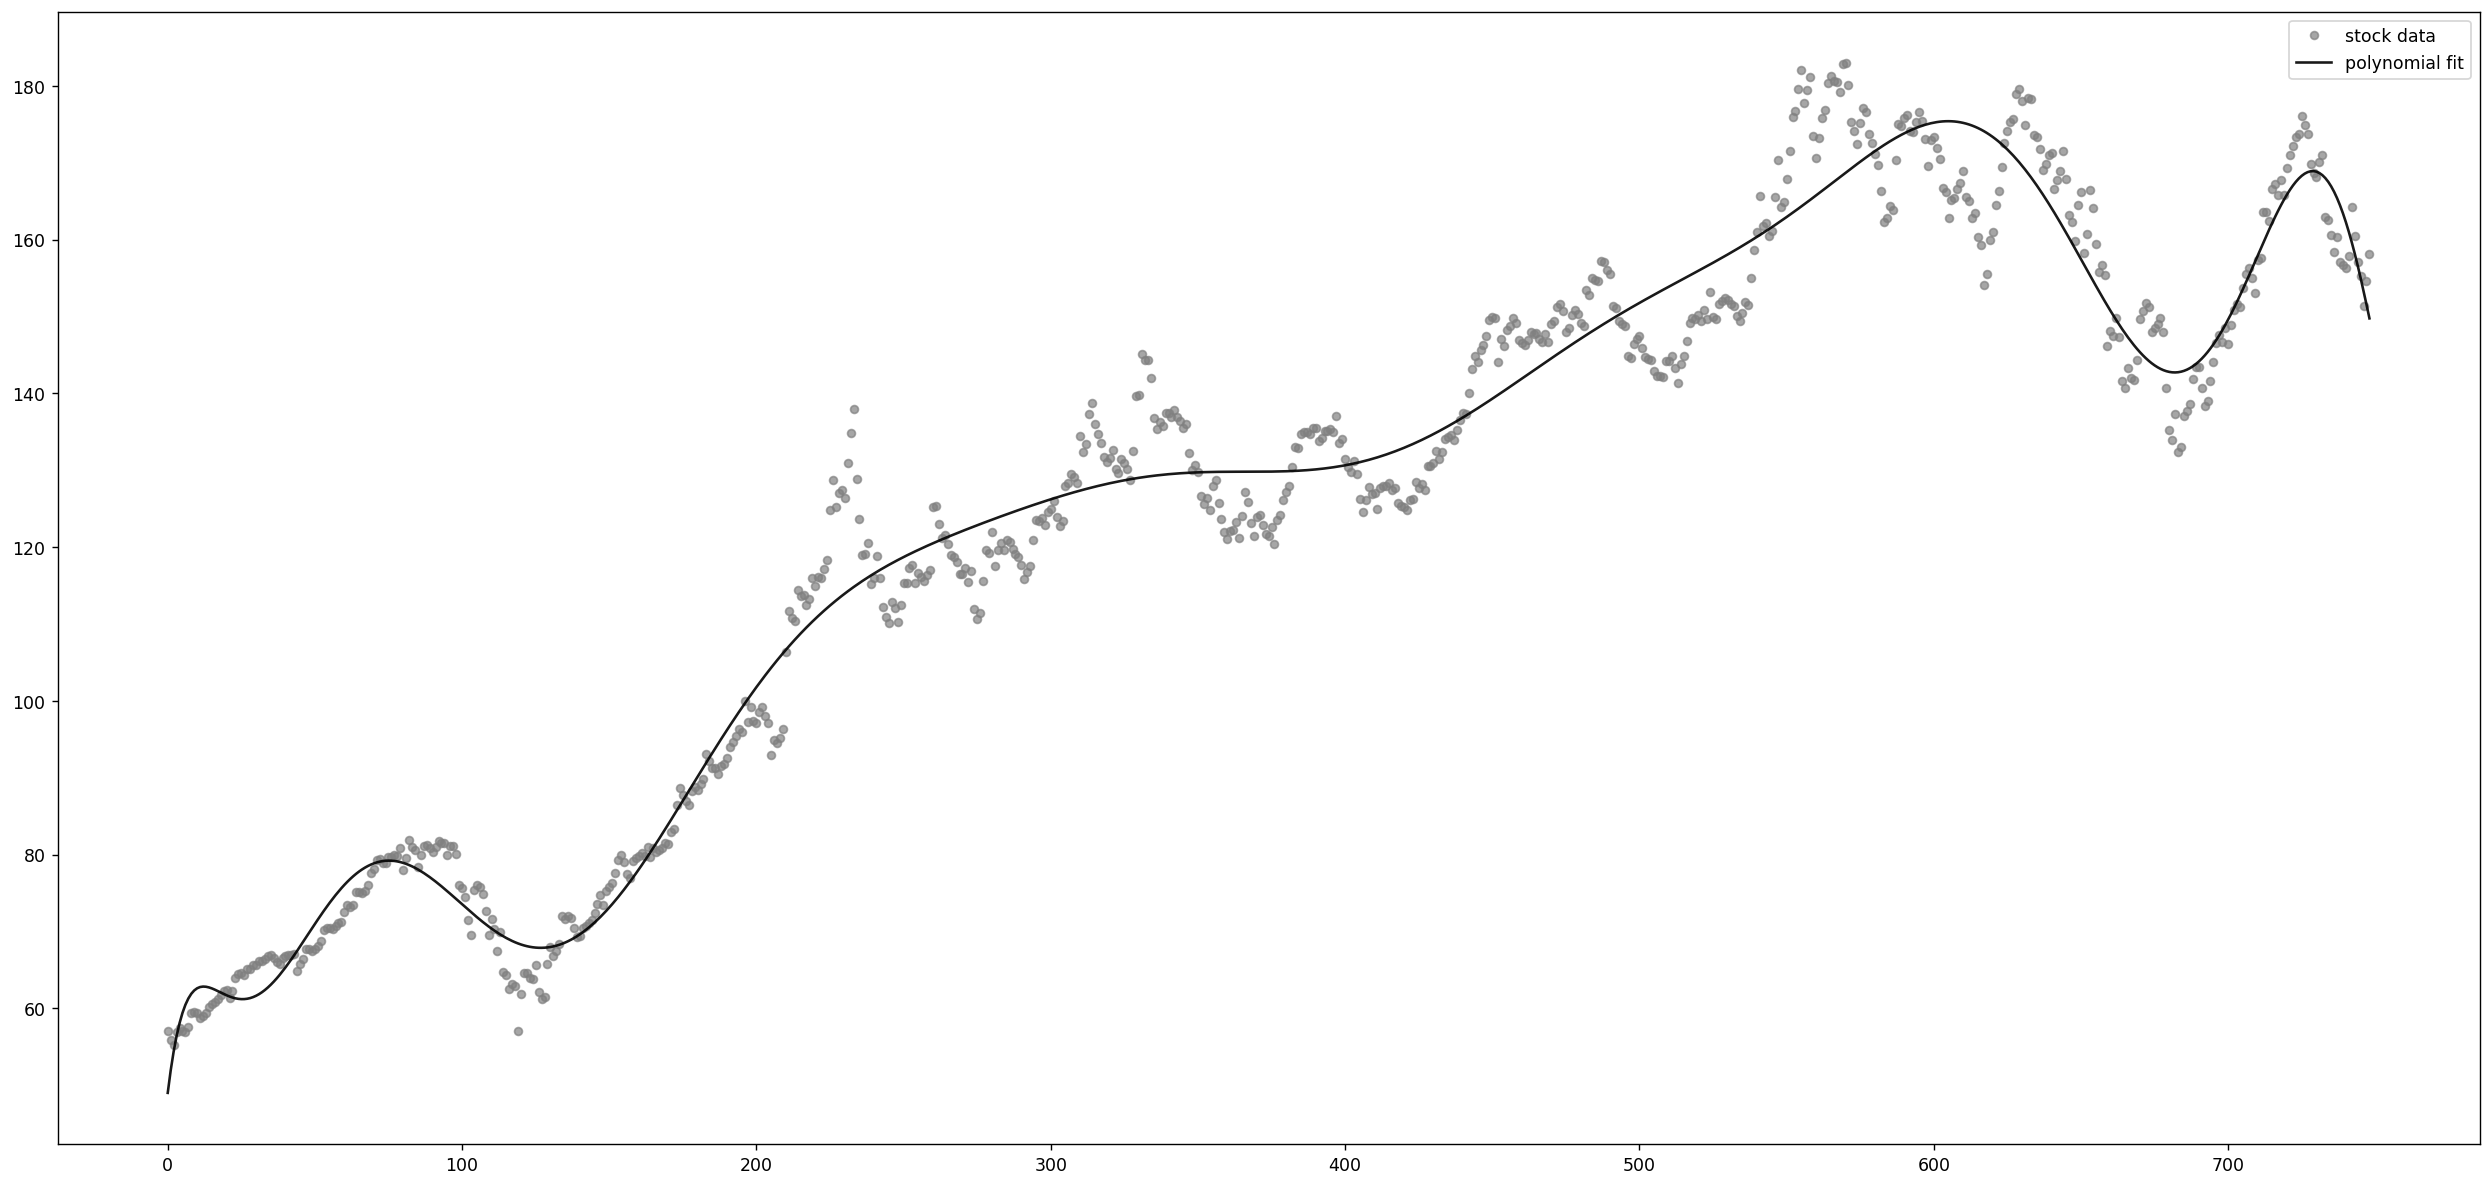

In [4]:
# discrete dataset
x_data = ticker_df.index.tolist()      # the index will be our x axis, not date

y_data = ticker_df['High']

 
# x values for the polynomial fit
#x = np.linspace(0, 100, 100)
x = np.linspace(0, max(ticker_df.index.tolist()), max(ticker_df.index.tolist()) + 1)


# polynomial fit of degree xxx
pol = np.polyfit(x_data, y_data,15) #with hit and trial arrive at degree of 15
y_pol = np.polyval(pol, x)

# ___ plotting ___
plt.figure(figsize=(25, 12), dpi= 125, facecolor='w', edgecolor='k')
# plot stock data
plt.plot(x_data, y_data, 'o', markersize=4.5, color='grey', alpha=0.7)
# plot polynomial fit
plt.plot(x, y_pol, '-', markersize=1.5, color='black', alpha=0.9)
plt.legend(['stock data', 'polynomial fit'])
plt.show()

[ 12  75 605 729]


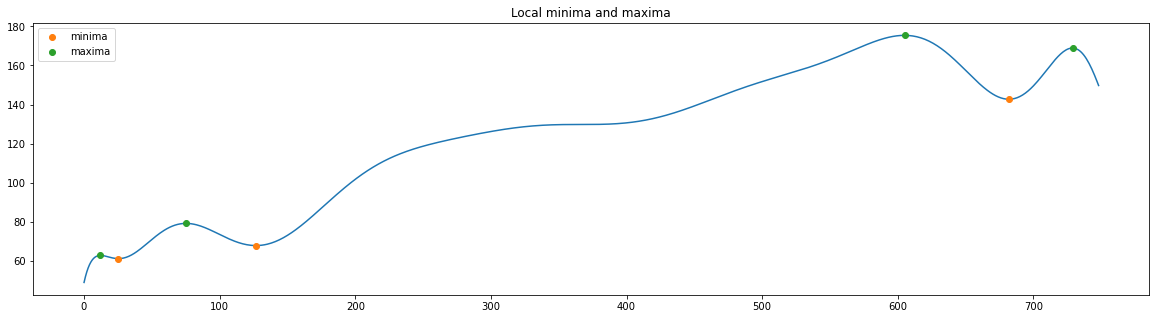

In [5]:
data = y_pol
 
#For curves with not too much noise
#                         ___ detection of local minimums and maximums ___

min_max = np.diff(np.sign(np.diff(data))).nonzero()[0] + 1          # local min & max
 
l_min = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1      # local min
 
l_max = (np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1      # local max
print(l_max)
 
# +1 due to the fact that diff reduces the original index number

# graphical output...
plt.figure(figsize=(20, 5))
plt.plot(x,data)
plt.plot(x[l_min], data[l_min], "o", label="minima")
plt.plot(x[l_max], data[l_max], "o", label="maxima")
plt.title('Local minima and maxima')
plt.legend()
plt.show()

In [6]:
print('corresponding HIGH values for suspected indices: ')
print(ticker_df.High.iloc[l_max])

#extend the suspected x range:
delta = 4                                        # how many bars to the left and to the right from local maximum on x axis

dict_i = dict()

for element in l_max:
    l_bound = element - delta                    # lower bound
   
    u_bound = element + delta                    # upper bound
    
    x_range = range(l_bound, u_bound + 1)

    y_loc_list = list()
    for x_element in x_range:
        y_loc_list.append(ticker_df.High.iloc[x_element]) 
        #print(y_loc_list)   
    dict_i[element] = y_loc_list
#print('DICTIONARY for l_max: ', dict_i)

corresponding HIGH values for suspected indices: 
12      59.037498
75      79.684998
605    162.850006
729    168.710007
Name: High, dtype: float64


In [7]:
y_delta = 0.05                              # assume percentage distance between average highs
threshold = max(ticker_df['High']) * 0.90   # set some  threshold value lower than the global high


y_dict = dict()
maxi = list()
suspected_tops = list()

for key in dict_i.keys():
    mn = sum(dict_i[key])/len(dict_i[key])
    maxi.append(max(dict_i[key]))
    l_y = mn * (1.0 - y_delta)
    u_y = mn * (1.0 + y_delta)
    y_dict[key] = [l_y, u_y, mn]


print('PROCESSING TO FIND DOUBLE TOP:')    
print(y_dict)
for key_i in y_dict.keys():  
    
    for key_j in y_dict.keys():   
       
        if (key_i != key_j) and (y_dict[key_i][2] > threshold):
            if (y_dict[key_i][2] < y_dict[key_j][1]) and (y_dict[key_i][2] > y_dict[key_j][0]):
                print('----------------------- ')
                print('--- top pattern found for x index pair: ', key_i, ',', key_j)
                suspected_tops.append(key_i)
                print('----------------------- ')
            else:
                print('Still Not found  ')

PROCESSING TO FIND DOUBLE TOP:
{12: [56.704972415500215, 62.67391688028972, 59.689444647894966], 75: [75.64322170681424, 83.60566609700521, 79.62444390190973], 605: [158.611999935574, 175.30799992879233, 166.95999993218317], 729: [162.08688863118488, 179.14866638183594, 170.6177775065104]}
Still Not found  
Still Not found  
----------------------- 
--- top pattern found for x index pair:  605 , 729
----------------------- 
Still Not found  
Still Not found  
----------------------- 
--- top pattern found for x index pair:  729 , 605
----------------------- 


In [ ]:
print(y_dict)

# ___ plotting ___
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
# plot stock data
plt.plot(x_data, y_data, 'o', markersize=3.5, color='grey', alpha=0.7)
# plot polynomial fit
plt.plot(x, y_pol, '-', markersize=1.0, color='black', alpha=0.9)
plt.legend(['AAPL stock data', 'polynomial fit'])

for position in suspected_tops:
    plt.axvline(x=position)

plt.axhline(threshold)    

plt.show()

Sources:
https://www.learndatasci.com/tutorials/python-finance-part-yahoo-finance-api-pandas-matplotlib/
https://stackoverflow.com/questions/4624970/finding-local-maxima-minima-with-numpy-in-a-1d-numpy-array
